Installing requirements

In [1]:
import util
from psfdataset import PSFDataset, transforms
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange

In [2]:
"""
script to compute the number
of jsons created for each
word. The output is a .csv
file where for each word the
number of jsons corresponding
to train, val, and test subsets
is mentioned
"""

import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def get_rect_and_landmarks(rect, landmarks):
    # converts and returns the face rectangle and landmarks
    # in formats appropriate for the display function

    x = rect["left"]
    y = rect["top"]
    w = rect["width"]
    h = rect["height"]

    if landmarks is not None:
        temp_agg = list()
        for i in range(len(landmarks)):
            temp = list()
            temp.append(landmarks["point-" + str(i+1)]["x"])
            temp.append(landmarks["point-" + str(i+1)]["y"])
            temp_agg.append(temp)
        return (x, y, w, h), np.asarray(temp_agg)
    else:
        return (x, y, w, h), np.empty((0, 0))


def choose_the_largest_face(faces_list):
    if len(faces_list) == 1: 
        return faces_list[0]
    
    area_max = 0
    area_max_id = 0
    for i,face in enumerate(faces_list):
        (face_rect,landmarks) = face
        area = face_rect[2] * face_rect[3] # area = width * height
        if area > area_max:
            area_max = area
            area_max_id = i
    return faces_list[area_max_id]


def load_one_json_file(filename, isDebug=False):
    # load the metadata and facial landmarks

    face_rect_list = []
    landmarks_list = []
    with open(filename) as f:
        video_data_dict = json.load(f)
        # extract duration
        if video_data_dict["metaData"] is not None:
            duration = float(re.findall(r"[-+]?\d*\.\d+|\d+", video_data_dict["metaData"]["Duration"])[0])
            if isDebug:
                print("duration metadata: %.3f" % duration)

        # extract frame information aggregated for all frames
        agg_frame_data = video_data_dict["aggFrameInfo"]  # list of frame-wise visual data

        for frame_data in agg_frame_data:
            n_faces = frame_data["numFaces"]
            if isDebug:
                print("frame index: %d number of faces: %d" % (frame_data["frameIndex"], n_faces))
            
            if frame_data["facialAttributes"] is not None:# if so, the n_faces should > 0 
                faces_list = []
                for attr in frame_data["facialAttributes"]:
                    face_idx = attr["faceIndex"]
                    face_rect, landmarks = get_rect_and_landmarks(attr["faceRectangle"],
                                                                  attr["faceLandmarks"])
                    faces_list.append((face_rect, landmarks))

                face_rect_chosen, landmarks_chosen = choose_the_largest_face(faces_list)    
                face_rect_list.append(face_rect_chosen)
                landmarks_list.append(landmarks_chosen)
    
    face_rect_array = np.array(face_rect_list)
    landmarks_array = np.array(landmarks_list)
    return face_rect_array, landmarks_array








i_data = "/cache/lrw/lipread_landmarks/dlib68_2d_sparse_json/lipread_mp4"
# or i_data = "/cache/lrw/lipread_landmarks/dlib68_2d_sparse_json_defects_not_one_face/lipread_mp4"
selected_n_classes = 10 # the max is 500

cnt = 0
data = dict()

for word in os.listdir(i_data):
    if not word.startswith('.'):
        cnt += 1
        if cnt > selected_n_classes:
            break
        print(cnt,word)
        splits = dict() # 'train' 'val' and 'test' sets
        # print("analysing data for the word: '%s'" % word)
        p = os.path.join(i_data, word)
        
        for sub_dir in os.listdir(p):
            if not sub_dir.startswith('.'):
                # print(sub_dir)
                p_sub = os.path.join(p, sub_dir)
                for _, _, files in os.walk(p_sub):
                    samples_list = []
                    for filename in files:
                        if filename.endswith('.json'):
                            face_rect_array, landmarks_array = load_one_json_file(os.path.join(p_sub, filename))
                            samples_list.append(landmarks_array)
                    splits[sub_dir] = samples_list
        data[word] = splits

print('-------------------------------')
print(data.keys()) # names of all the 'selected_n_classes' classes  
print(data['THOUGHT'].keys()) # print the names of the 3 splits for the first class 'THOUGHT'
print(len(data['THOUGHT']['train'])) # print the number of train samples of the first class
print(data['THOUGHT']['train'][0].shape) # print the shape (29 frames, 68 landmarks, 2 coordinates) of the first training sample of the first class    
print('-------------------------------')                     
        


1 THOUGHT
2 INVOLVED
3 DIFFERENT
4 MAYBE
5 REPORT
6 VICTIMS
7 GETTING
8 UNION
9 MEDIA
10 VIOLENCE
-------------------------------
dict_keys(['THOUGHT', 'INVOLVED', 'DIFFERENT', 'MAYBE', 'REPORT', 'VICTIMS', 'GETTING', 'UNION', 'MEDIA', 'VIOLENCE'])
dict_keys(['val', 'test', 'train'])
1000
(29, 68, 2)
-------------------------------


# Step 0: Defining a LabelEncoder to transform text class to numberic class

In [3]:
encoder= LabelEncoder()
categories = list(data.keys())
encoder.fit(categories)

LabelEncoder()

# Step 1: Defining my custom Data loader from above 'data'. We only need to properly define iterators for train/test/validation sets

In [10]:
def generate_iterator(data, key = 'train', refLength = 29):
    iter_list = []
    x = 0
    for word, keypointsOneWord in data.items():
        

        keypointsList = keypointsOneWord[key]
        num_of_samples = len(keypointsList)
        
        ## There are some sample whose length is smaller than 29. We need to either delete it, 
        ## or extend it to 29 length for now. But this can be resolved if signature transform is introduced
        for i in range(len(keypointsList)):
            singleSample = keypointsList[i]
            if len(singleSample) < refLength:
                singleSample = np.array(list(singleSample) + [singleSample[-1]] * (refLength - len(singleSample)))
                keypointsList[i] = singleSample
        iter_list = iter_list + list(zip(keypointsList, np.array(list(encoder.transform([word])) * num_of_samples)))
    return iter(iter_list)

In [11]:
keypointsOneWord = data['THOUGHT']

In [12]:
iter_train = generate_iterator(data, key = 'train')
iter_test = generate_iterator(data, key = 'test')
iter_val = generate_iterator(data, key = 'val')

In [13]:
iiter_test = [x for x in iter_test]
iiter_train = [x for x in iter_train]

# Step 2: Let's adapt the PSFDataset from human body movement

In [28]:
tr = transforms.Compose([
    transforms.spatial.Crop(),
    transforms.spatial.Normalize(),
    transforms.SpatioTemporalPath(),
    transforms.temporal.MultiDelayedTransformation(2),
    transforms.temporal.DyadicPathSignatures(dyadic_levels=1,
                                             signature_level=3)
])

As first steps, no transforms are introduced yet.

In [29]:
trainingset = PSFDataset(transform = tr) 
testset = PSFDataset(transform = tr)
valset  = PSFDataset(transform = tr)

trainingset.fill_from_iterator(generate_iterator(data, 'train'))
testset.fill_from_iterator(generate_iterator(data, 'test'))
valset.fill_from_iterator(generate_iterator(data, 'val'))


print("Number of trainingset elements:", len(trainingset))
print("Number of testset elements", len(testset))
print("Dimension of feature vector:", trainingset.get_data_dimension())

10000it [04:26, 37.51it/s]
500it [00:13, 37.68it/s]
500it [00:13, 37.65it/s]

Number of trainingset elements: 10000
Number of testset elements 500
Dimension of feature vector: 16320


# Step 3: Training model using trainingset

In [30]:
device = torch.device('cpu')

In [31]:
# torch.manual_seed(0)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(0)

In [32]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("Device:", device)

In [33]:
class LinearClassifierNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        self.linear1 = torch.nn.Linear(input_dim, 2048)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.output = torch.nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.output(x)
        return x

model = LinearClassifierNet(input_dim=trainingset.get_data_dimension(),
                            output_dim=selected_n_classes) # selected_n_classes = 10 (maximum 500)
model.to(device=device, dtype=torch.double)

LinearClassifierNet(
  (linear1): Linear(in_features=16320, out_features=2048, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=2048, out_features=10, bias=True)
)

In [34]:
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20

In [35]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [36]:
training_loader = torch.utils.data.DataLoader(trainingset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=2)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

In [37]:
# iter_dataloader = [(i, data) for i,data in enumerate(training_loader)]

In [38]:
def train_network(epoch):
    model.train()
    cumulated_loss = 0.0
    for i, data in tqdm(enumerate(training_loader), desc="Epoch " + str(epoch), leave=False):
        inputs, labels = data[0].to(device, dtype = torch.double), data[1].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        cumulated_loss += loss.item()
    return (cumulated_loss / len(training_loader))

def test_network():
    cumulated_outputs = np.array([])
    cumulated_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device, dtype = torch.double), data[1].to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            cumulated_loss += loss.item()

            outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            cumulated_outputs = np.concatenate((cumulated_outputs, outputs.cpu().numpy()), axis=None)
        test_loss = cumulated_loss / len(test_loader)
        return test_loss, cumulated_outputs

In [39]:
# Print initial accuracy before training
__, outputs = test_network()
acc = accuracy_score(testset.get_labels(), outputs)
print("Initial accuracy:", acc)

for epoch in trange(EPOCHS, desc="Training"):
    train_loss = train_network(epoch)
    test_loss, outputs = test_network()
    
    acc = accuracy_score(testset.get_labels(), outputs)
    print("train_loss:", train_loss, "\ttest_loss:", test_loss, "\tAccuracy:", acc)

Initial accuracy: 0.1


train_loss: 2.371220605553727 	test_loss: 2.0506173469651827 	Accuracy: 0.29


train_loss: 2.0687464830744418 	test_loss: 2.045921377701269 	Accuracy: 0.28


train_loss: 1.9057712307988368 	test_loss: 1.7893026386385182 	Accuracy: 0.33


train_loss: 1.8349142022575209 	test_loss: 1.8548962643535645 	Accuracy: 0.368


train_loss: 1.761267351894063 	test_loss: 1.6403316577707256 	Accuracy: 0.38


train_loss: 1.700408110326513 	test_loss: 1.710134110295484 	Accuracy: 0.39


train_loss: 1.6657708384631424 	test_loss: 1.6250675147328775 	Accuracy: 0.394


train_loss: 1.6600326371605154 	test_loss: 1.5587597942590994 	Accuracy: 0.438


train_loss: 1.625965679172285 	test_loss: 1.5708363842950994 	Accuracy: 0.422


train_loss: 1.5899251826866574 	test_loss: 1.5666943126829025 	Accuracy: 0.46


train_loss: 1.5911451743757672 	test_loss: 1.5205326659295895 	Accuracy: 0.44


train_loss: 1.5583936740962652 	test_loss: 1.6204430761219004 	Accuracy: 0.43


train_loss: 1.5415467968537098 	test_loss: 1.513698640026821 	Accuracy: 0.464


train_loss: 1.5172724456054296 	test_loss: 1.5102168956300226 	Accuracy: 0.442


train_loss: 1.5180664072242014 	test_loss: 1.5180752423918134 	Accuracy: 0.458


train_loss: 1.511302455823756 	test_loss: 1.4816961943448665 	Accuracy: 0.452


train_loss: 1.4955038837029606 	test_loss: 1.6090066885980134 	Accuracy: 0.424


train_loss: 1.4746863701960138 	test_loss: 1.5257679250243508 	Accuracy: 0.456


train_loss: 1.474155533703511 	test_loss: 1.4194269430824273 	Accuracy: 0.494


train_loss: 1.4604723538355768 	test_loss: 1.5521472859069738 	Accuracy: 0.436



## Showing the confusion matrix

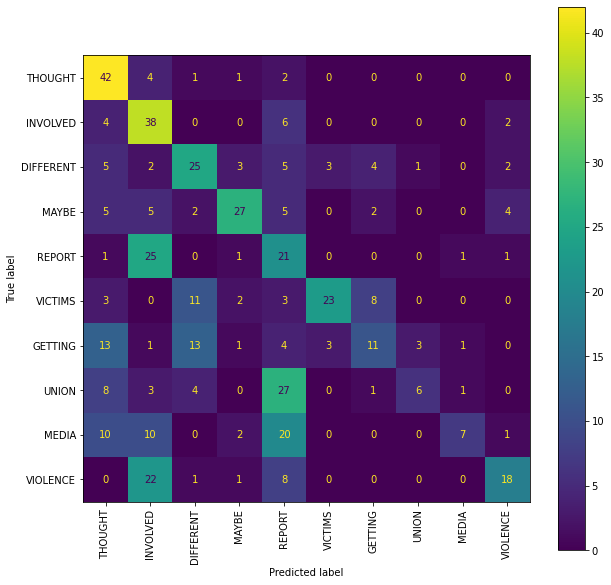

In [41]:
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(testset.get_labels(), outputs)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels=data.keys()).plot(ax=ax,
                                                                       xticks_rotation="vertical")

# (Not useful for modelling) Some visualization

In [3]:
def return_landmark_df(landmarks_array):
    landmarks_dict = {}
    order = 0
    for frame in landmarks_array:
        landmarks_dict[order] = pd.DataFrame(frame)
        order += 1
    return landmarks_dict

In [4]:
landmarks_dict = return_landmark_df(landmarks_array)
landmarks_df = pd.concat(landmarks_dict)

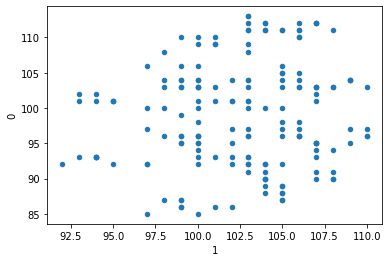

In [36]:
ax = landmarks_df.xs(36, level = 1).plot.scatter(1, 0)#, c = landmarks_df.index.get_level_values(0), title = filename)
for ind in np.arange(37, 42, 1):
    landmarks_df.xs(ind, level = 1).plot.scatter(1, 0, ax = ax)

In [7]:
def visualize_one_landmark_flow(landmarks_array, filename = '', inOneGraph = True):
    for frame in landmarks_array:
        plt.scatter(frame[:, 1], frame[:, 0], )
        plt.title(filename)
        if not inOneGraph:
            plt.figure()

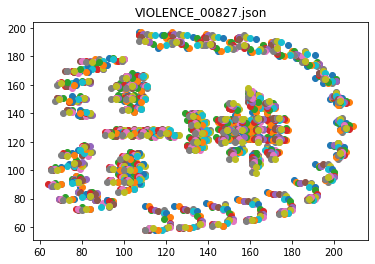

In [9]:
visualize_one_landmark_flow(landmarks_array, filename)

In [27]:
landmarks_array.shape

(29, 68, 2)

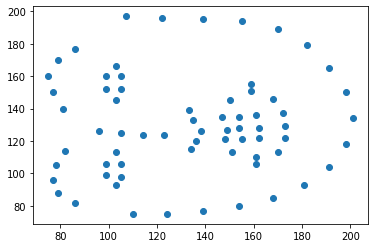

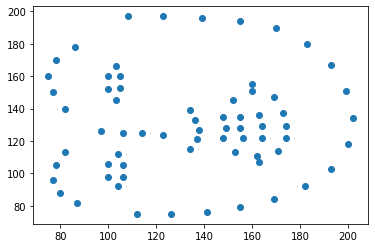

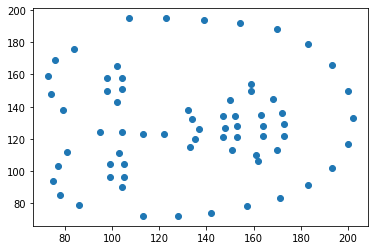

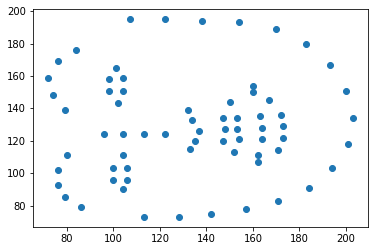

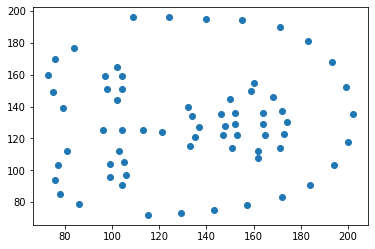

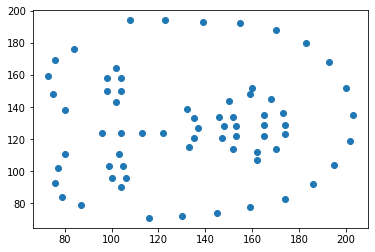

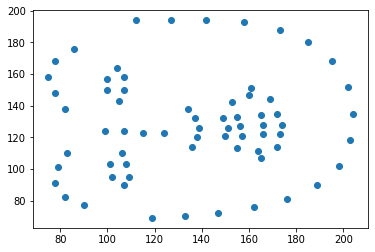

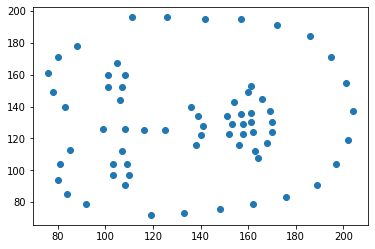

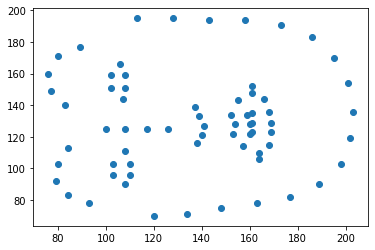

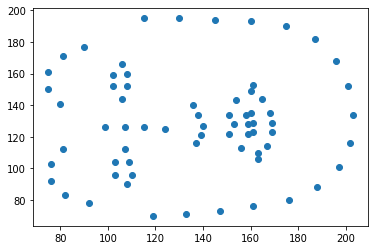

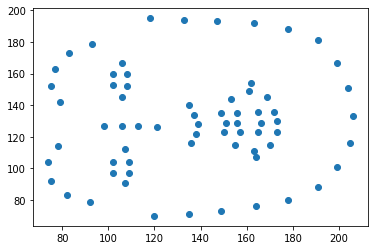

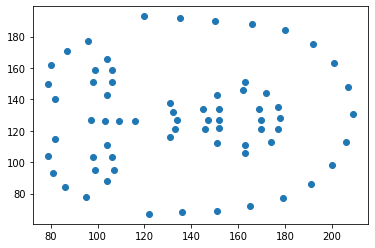

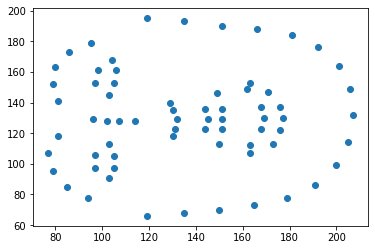

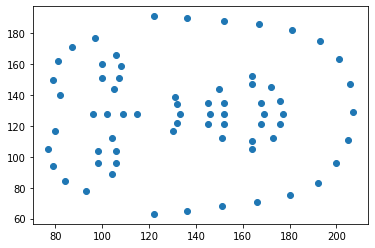

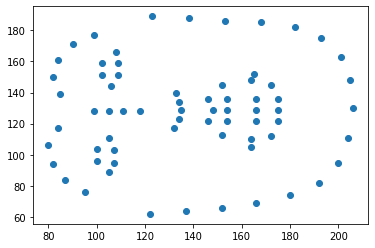

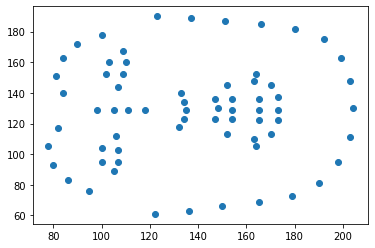

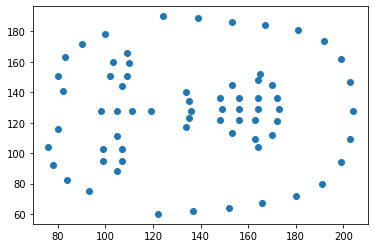

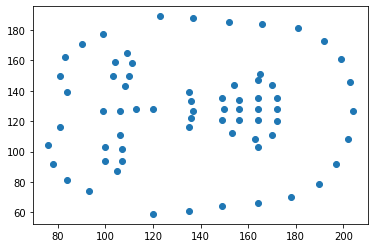

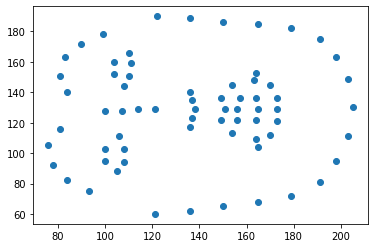

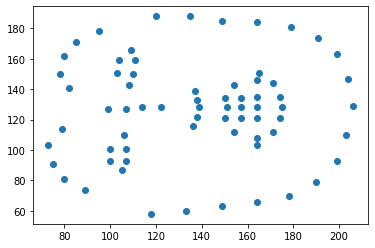

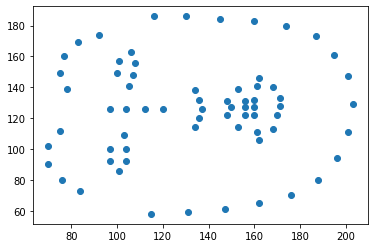

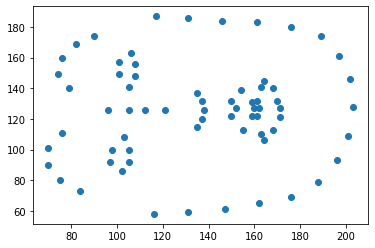

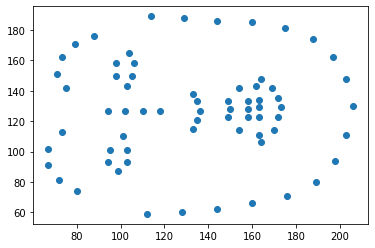

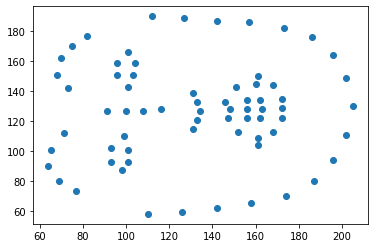

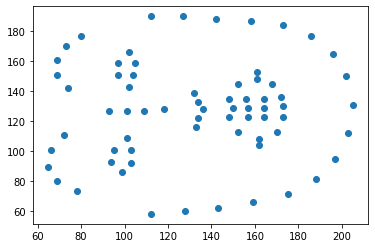

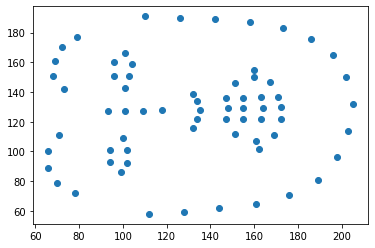

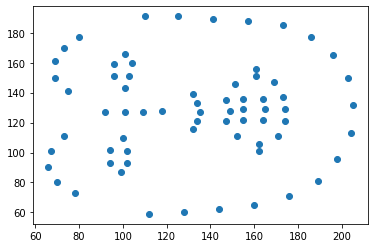

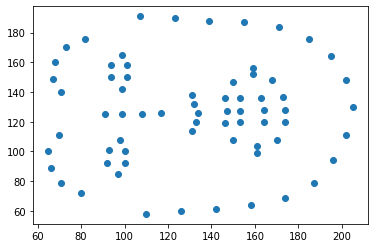

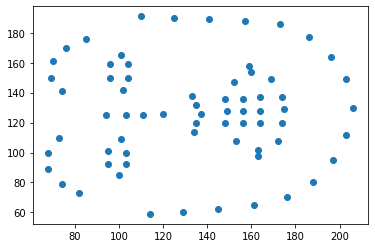

<Figure size 432x288 with 0 Axes>

In [10]:
visualize_one_landmark_flow(landmarks_array, inOneGraph=False)

## Using provided animation tool to generate short video

In [18]:
any_video_path = 'datasets/jhmdb_dataset/videos/golf/Eric_Axley_golf_f_cm_np1_le_goo_0.avi'

In [19]:
util.display_animation(any_video_path, landmarks_array, include_source_video = False)

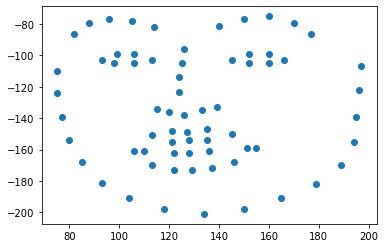

In [60]:
plt.scatter(landmarks_array[0][:, 0], -landmarks_array[0][:, 1]) 